In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import seaborn as sns
plt.rc('font', family='Malgun Gothic') 

In [2]:
 # 지수표현 없애기
pd.options.display.float_format = '{:.5f}'.format
# 원래대로
# pd.reset_option('display.float_format')



### data load


In [3]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [8]:
def make_month(df):
    dt = df['base_date'].astype('str')
    month_data = pd.to_datetime(dt)
    md = month_data.dt.month
    return md

train['month'] = make_month(train)
test['month'] = make_month(test)

### 기초 통계량

In [4]:
round(train.describe(), 4)

,base_date,base_hour,road_in_use,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000,4701217.00000
mean,20216717.75500,11.92820,0.00140,1.83670,104.95850,0.00050,0.26600,61.25330,0.00000,5618.74240,0.00000,0.61520,33.38430,126.52170,33.38430,126.52170,42.78840
std,4555.70860,6.72210,0.03690,0.68780,1.84010,0.02180,5.22780,12.13350,0.00000,13953.43320,0.00000,1.21130,0.10120,0.15640,0.10120,0.15640,15.95440
min,20210901.00000,0.00000,0.00000,1.00000,103.00000,0.00000,0.00000,30.00000,0.00000,0.00000,0.00000,0.00000,33.24340,126.18260,33.24340,126.18260,1.00000
25%,20211104.00000,6.00000,0.00000,1.00000,103.00000,0.00000,0.00000,50.00000,0.00000,0.00000,0.00000,0.00000,33.26420,126.42320,33.26420,126.42320,30.00000
50%,20220128.00000,12.00000,0.00000,2.00000,106.00000,0.00000,0.00000,60.00000,0.00000,0.00000,0.00000,0.00000,33.41260,126.51120,33.41260,126.51120,43.00000
75%,20220503.00000,18.00000,0.00000,2.00000,107.00000,0.00000,0.00000,70.00000,0.00000,0.00000,0.00000,0.00000,33.47800,126.58400,33.47800,126.58400,54.00000
max,20220731.00000,23.00000,1.00000,3.00000,107.00000,1.00000,103.00000,80.00000,0.00000,50000.00000,0.00000,3.00000,33.55610,126.93090,33.55610,126.93090,113.00000


### 상관계수

데이터간의 상관성이 없음(위, 경도제외)


In [7]:
train.corr()

,base_date,base_hour,road_in_use,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
base_date,1.00000,-0.00864,-0.00180,0.01146,0.01855,0.00083,-0.01063,-0.01871,NaN,-0.01103,NaN,-0.00460,-0.01682,-0.00495,-0.01679,-0.00497,-0.03400
base_hour,-0.00864,1.00000,-0.00119,-0.02919,0.03166,0.00571,-0.00265,-0.03676,NaN,-0.00323,NaN,-0.00788,-0.02160,-0.01148,-0.02160,-0.01149,-0.15941
road_in_use,-0.00180,-0.00119,1.00000,0.00877,-0.03340,-0.00081,-0.00188,-0.00382,NaN,-0.01487,NaN,-0.01876,-0.02783,0.01820,-0.02857,0.01827,0.02609
lane_count,0.01146,-0.02919,0.00877,1.00000,-0.09572,-0.02655,-0.02929,0.38400,NaN,-0.17722,NaN,-0.05071,0.18267,-0.09481,0.18233,-0.09473,-0.14426
road_rating,0.01855,0.03166,-0.03340,-0.09572,1.00000,0.02422,-0.05416,-0.32747,NaN,-0.11863,NaN,-0.12562,-0.20479,0.00740,-0.20484,0.00739,-0.26169
multi_linked,0.00083,0.00571,-0.00081,-0.02655,0.02422,1.00000,-0.00111,-0.02024,NaN,-0.00879,NaN,0.04298,-0.01491,0.02690,-0.01491,0.02690,-0.00841
connect_code,-0.01063,-0.00265,-0.00188,-0.02929,-0.05416,-0.00111,1.00000,-0.01519,NaN,-0.02049,NaN,-0.02585,0.03662,-0.04569,0.03716,-0.04485,0.04835
maximum_speed_limit,-0.01871,-0.03676,-0.00382,0.38400,-0.32747,-0.02024,-0.01519,1.00000,NaN,0.08508,NaN,0.05951,0.25315,-0.03302,0.25296,-0.03291,0.42572
vehicle_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_restricted,-0.01103,-0.00323,-0.01487,-0.17722,-0.11863,-0.00879,-0.02049,0.08508,NaN,1.00000,NaN,0.79280,-0.12829,0.03493,-0.12831,0.03492,0.29409


### Label encoding

In [8]:
str_col = ['day_of_week', 'start_turn_restricted', 'end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

### EDA

In [16]:
def print_mode(df, col):    
    cnt = Counter(df[col])
    list_cnt = cnt.most_common(3)

    for idx, value in enumerate(list_cnt):
        print(f'{col}의 최빈값 {idx+1}순위 : {value[0]} & {value[-1]}개')
    
    
def print_statistics(df, col):    
    max = df['target'].max()
    min = df['target'].min()
    mean = df['target'].mean()
    median = df['target'].median()

    print(f'{col}의 최대값 : {max}')
    print(f'{col}의 최소값 : {min}')
    print(f'{col}의 평균값 : {mean}')
    print(f'{col}의 중앙값 : {median}')
    print_mode(df, col)
  
  
def histogram_plt(df, col):    
    sns.histplot(data=df[col], kde=True)
    print_statistics(df, col)
  

def count_plt(df, col, target='target'):    
    print(df[col].value_counts())

    sns.countplot(data=df, x=col)
    plt.show()
    
def value_hist(df, col, target='target'):
    for value in df[col].unique():
        cond = (df[col]==value)
        cond_df = df.loc[cond]

        print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')

        print_statistics(cond_df, target)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

        sns.boxplot(data=cond_df, x='target', ax=ax[1])
        ax[1].set_title(f'{col}의 {value} Box Plot')

        sns.histplot(data=cond_df, x='target', ax=ax[0])
        ax[0].set_title(f'{col}의 {value} 히스토그램')
        ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

        plt.show()

### 평균속도(km) = target
30~60까지 분포가 많고, 60이상으로는 쭉 떨어지는 양상을 보임

target의 최대값 : 113.0
target의 최소값 : 1.0
target의 평균값 : 42.78844180134633
target의 중앙값 : 43.0
target의 최빈값 1순위 : 48.0 & 112044개
target의 최빈값 2순위 : 49.0 & 110244개
target의 최빈값 3순위 : 50.0 & 108822개


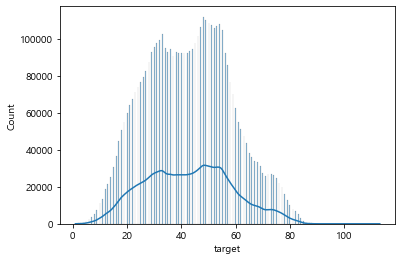

In [6]:
# target의 분포
histogram_plt(train, 'target')

### 시간대(base_hour)

오후시간(13~ )에 통행량이 가장 많고 새벽에는 통행량 감소

저녁시간의 통량량이 생각보다 적음

오후 > 출근시간 > 저녁 > 밤 > 새벽

15    214541
13    214297
14    214182
12    211833
19    209870
11    208515
16    208420
17    208377
18    207500
10    206316
9     205327
20    205059
21    203585
8     201875
22    200629
7     199061
6     189418
23    184229
1     182353
5     181128
2     169322
4     165284
3     155938
0     154158
Name: base_hour, dtype: int64


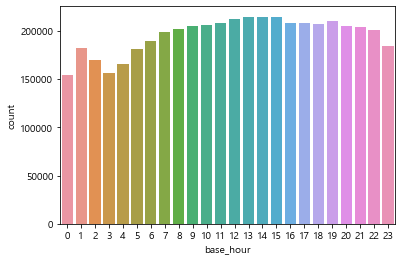

In [8]:
count_plt(train, 'base_hour')

In [24]:
train.groupby(['base_hour'])['target'].mean()

base_hour
0     48.742200
1     49.763300
2     50.278658
3     50.543254
4     49.747525
5     47.201140
6     45.549029
7     43.682268
8     41.656292
9     40.875939
10    40.222232
11    39.824593
12    39.838538
13    39.731471
14    39.561121
15    39.351700
16    39.127929
17    38.473363
18    38.241258
19    40.104112
20    41.113806
21    42.173431
22    43.989862
23    45.807739
Name: target, dtype: float64

### 요일(day_of_week)

금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: day_of_week, dtype: int64


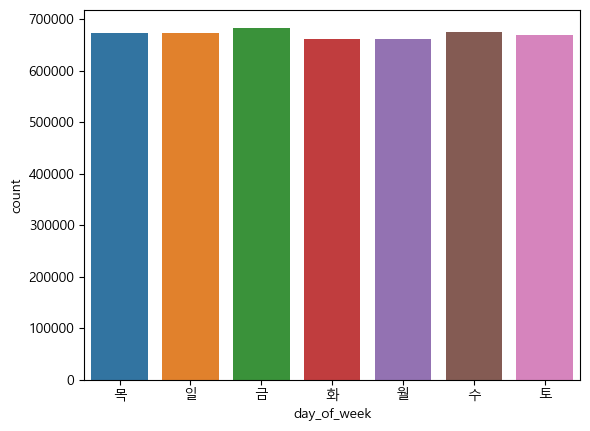

In [42]:
count_plt(train, 'day_of_week')

In [43]:
train.groupby(['day_of_week', 'month'])['target'].mean().to_csv('a.csv')

### 월 데이터(month)
데이터를 살펴보니 7월의 평균속도가 유난히 낮음 => 여름휴가때문이라고 추정

12    616511
9     570909
1     569884
2     550807
10    537916
3     505671
6     490137
5     463709
7     274695
11    120978
Name: month, dtype: int64


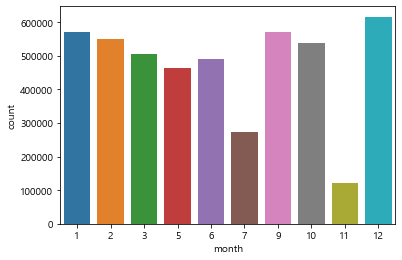

In [92]:
count_plt(train, 'month')

In [25]:
train.groupby(['month'])['target'].mean()
# 7월의 속도의 평균이 낮음

month
1     43.033130
2     43.256182
3     43.548673
5     42.639328
6     42.614157
7     36.282302
9     43.694340
10    43.495717
11    43.728215
12    43.030021
Name: target, dtype: float64

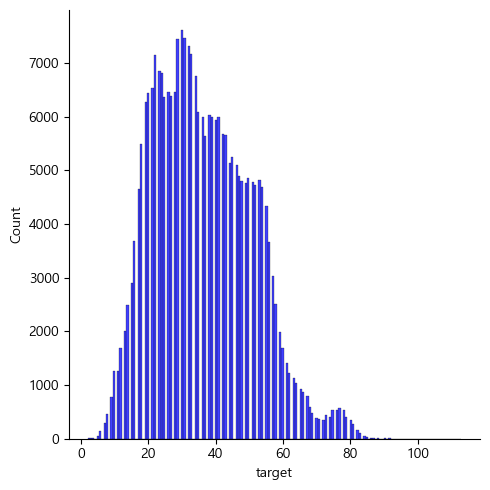

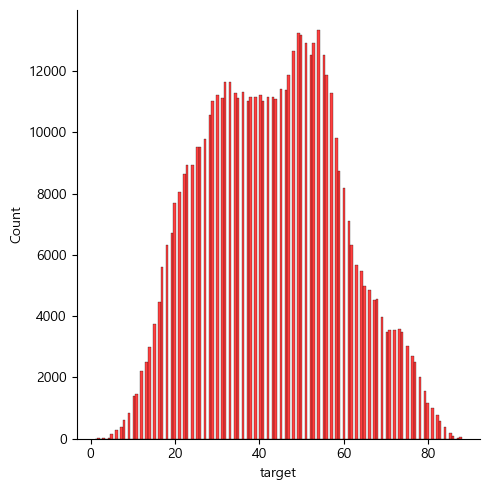

In [35]:
sns.displot(train[train['month']==7]['target'], color="blue", label='target')
sns.displot(train[train['month']==1]['target'], color="red", label='target')

### 요일(day_of_week)
요일에 따른 데이터의 특성을 파악해보기

금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: day_of_week, dtype: int64


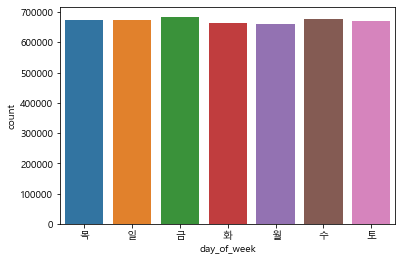

In [7]:
count_plt(train, 'day_of_week')

요일에 따른 도로 사용여부의 차이

In [24]:
train.groupby('day_of_week')['road_in_use'].sum()

day_of_week
금    939
목    918
수    903
월    895
일    939
토    933
화    878
Name: road_in_use, dtype: int64

In [95]:
train.groupby('day_of_week')['target'].mean()

day_of_week
금   42.45033
목   42.76834
수   42.77037
월   42.76137
일   43.17930
토   42.89412
화   42.69920
Name: target, dtype: float64

### 도로 사용 여부(road_in_use)
data imbalence로 1인 데이터의 특징과 비교를 한번 해볼 예정

0    4694812
1       6405
Name: road_in_use, dtype: int64


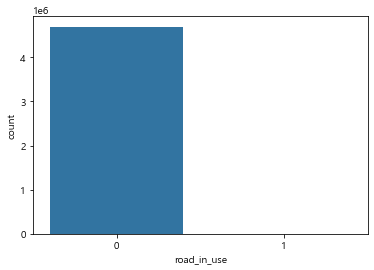

In [15]:
count_plt(train, 'road_in_use')

### 차로수(lane_count)

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64


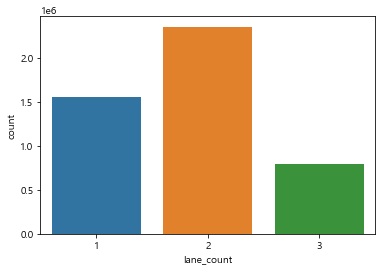

In [16]:
count_plt(train, 'lane_count')

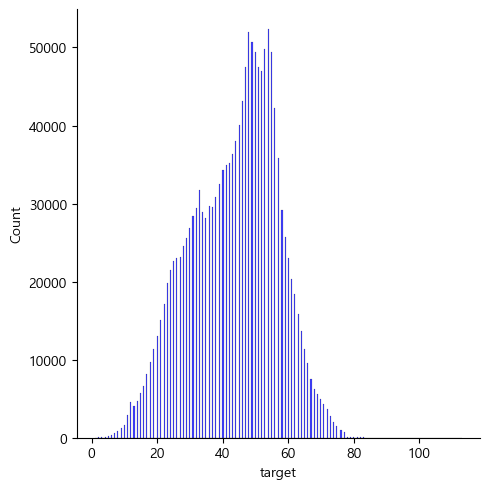

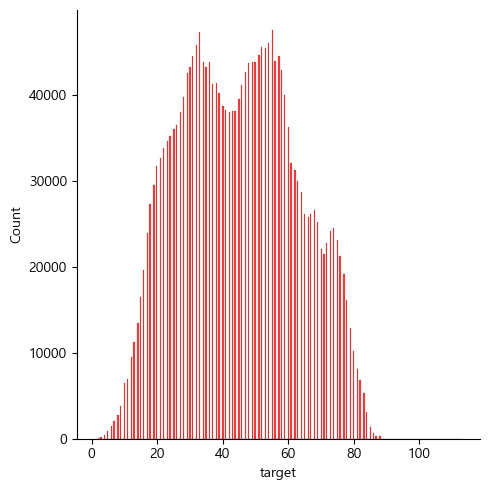

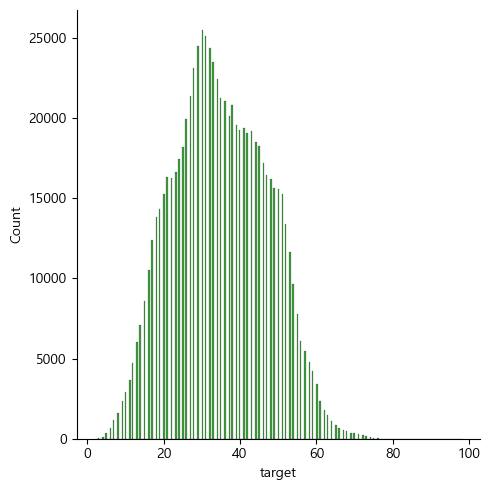

In [13]:
sns.displot(train[train['lane_count']==1]['target'], color="blue", label='target')
sns.displot(train[train['lane_count']==2]['target'], color="red", label='target')
sns.displot(train[train['lane_count']==3]['target'], color="green", label='target')

### 도로 등급(road_rating)

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64


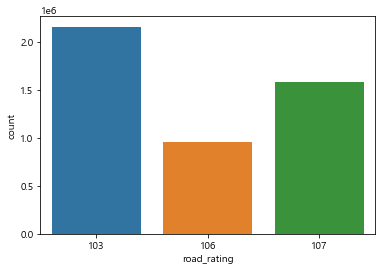

In [18]:
count_plt(train, 'road_rating')

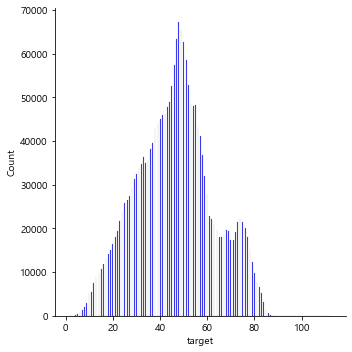

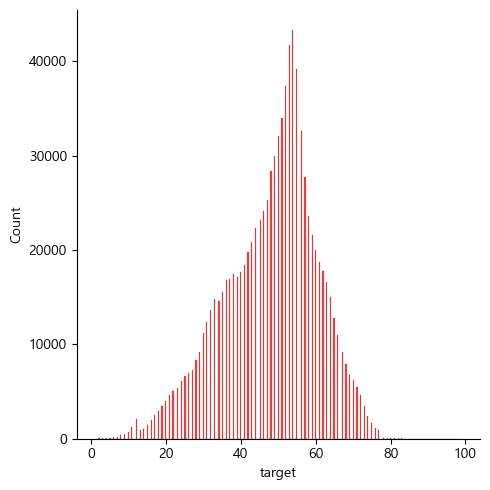

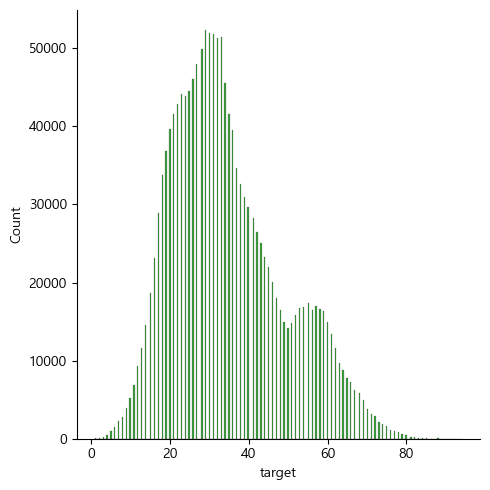

In [5]:
sns.displot(train[train['road_rating']==103]['target'], color="blue", label='target')
sns.displot(train[train['road_rating']==106]['target'], color="red", label='target')
sns.displot(train[train['road_rating']==107]['target'], color="green", label='target')

### 중용구간 여부(multi_linked)

0    4698978
1       2239
Name: multi_linked, dtype: int64


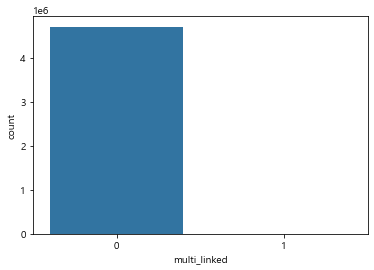

In [25]:
count_plt(train, 'multi_linked')

In [44]:
train.groupby(['multi_linked'])['target'].mean()

multi_linked
0    42.791370
1    36.642698
Name: target, dtype: float64

### 최고속도 제한(maximum_speed_limit)

60.00000    1665573
50.00000    1103682
70.00000     995077
80.00000     700334
30.00000     229761
40.00000       6790
Name: maximum_speed_limit, dtype: int64


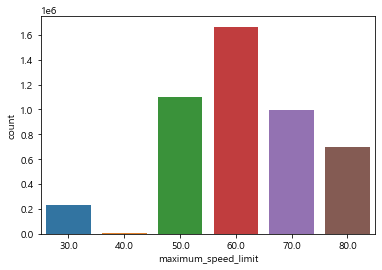

In [28]:
count_plt(train, 'maximum_speed_limit')

In [45]:
train.groupby(['maximum_speed_limit'])['target'].mean()

maximum_speed_limit
30.0    32.220825
40.0    62.774080
50.0    35.492231
60.0    42.316287
70.0    41.366208
80.0    60.703696
Name: target, dtype: float64

### 통과제한 하중(weight_restricted)

0.00000        4032874
43200.00000     410361
32400.00000     239305
50000.00000      18677
Name: weight_restricted, dtype: int64


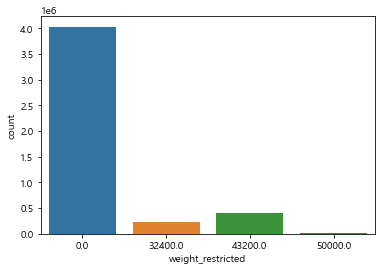

In [32]:
count_plt(train, 'weight_restricted')

In [23]:
train.groupby('weight_restricted')['target'].mean()

weight_restricted
0.0        40.955696
32400.0    47.453350
43200.0    57.883888
50000.0    47.088665
Name: target, dtype: float64

### 통과제한 높이(hight_restricted)
다 0

0.00000    4701217
Name: height_restricted, dtype: int64


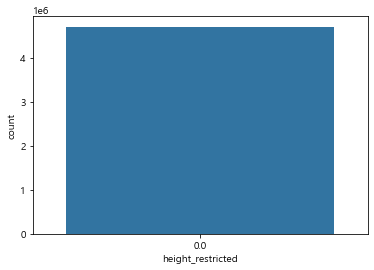

In [64]:
count_plt(train, 'height_restricted')

### 도로유형(road_type)

도로유형에 따른 속도차이가 있음

0    3737117
3     964100
Name: road_type, dtype: int64


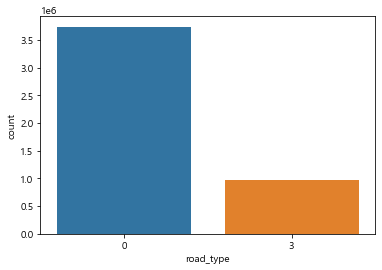

In [66]:
count_plt(train, 'road_type')

In [22]:
train.groupby('road_type')['target'].mean()

road_type
0    41.160930
3    49.097125
Name: target, dtype: float64

### 시작지점 회전제한 유무(start_turn_restricted)

없음    4239701
있음     461516
Name: start_turn_restricted, dtype: int64


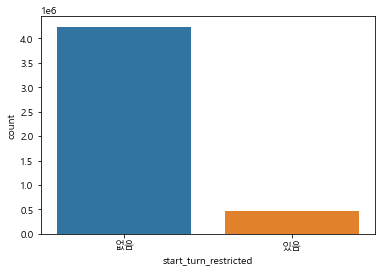

In [67]:
count_plt(train, 'start_turn_restricted')

In [21]:
train.groupby('start_turn_restricted')['target'].mean()

start_turn_restricted
없음    43.610246
있음    35.238967
Name: target, dtype: float64

### 도착지점 회전제한 유무(end_turn_restricted)

없음    4239599
있음     461618
Name: end_turn_restricted, dtype: int64


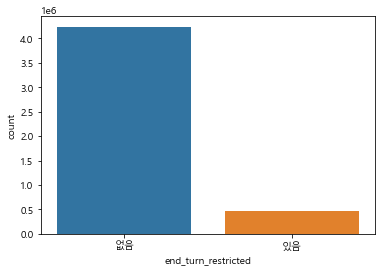

In [68]:
count_plt(train, 'end_turn_restricted')

In [20]:
train.groupby('end_turn_restricted')['target'].mean()

end_turn_restricted
없음    43.645590
있음    34.916206
Name: target, dtype: float64

### 연결로 코드(connect_code)
불균형한 데이터지만 연결로 코드에 따른 속도차이가 확실히 있음  
connect_code  
0      42.749190  
103    57.947043  
Name: target, dtype: float64

0      4689075
103      12142
Name: connect_code, dtype: int64


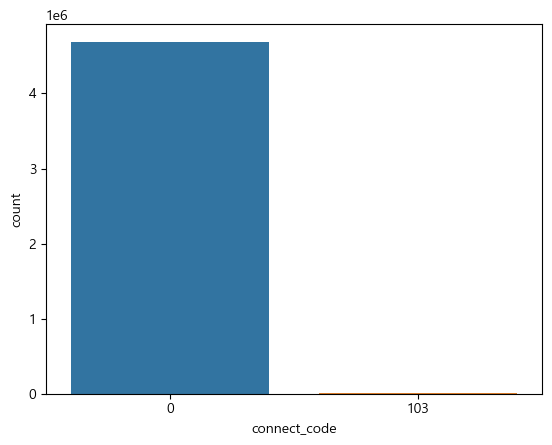

In [17]:
count_plt(train, 'connect_code')

### 통과제한 차량(vehicle_restricted)


0.00000    4701217
Name: vehicle_restricted, dtype: int64


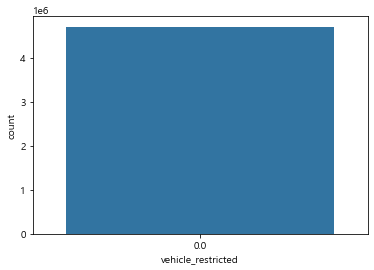

In [69]:
count_plt(train, 'vehicle_restricted')

In [5]:
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address


geocoding_reverse([train['start_latitude'][1], train['start_longitude'][1]])


Location(광양사거리, 동광로, 제주시, 제주특별자치도, 63208, 대한민국, (33.5007202, 126.529048, 0.0))

In [102]:
# feture 추가에 빠른 베이스라인 코드
# 0. baseline 3.9867
# 1. 월 추가 후 3.9269
# 2. turn_road_rate 추가 후 3.8746
# 3. end_turn_road_rate 추가 후 3.8543
# 4. 
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    

y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1103)
## 모델 선언 및 학습
LR = XGBRegressor(random_state=42).fit(x_train, y_train)
## 추론
y_pred = LR.predict(x_val)
mae = mean_absolute_error(y_val, y_pred)
mae

(4701217, 18)
(4701217,)


3.926955248432225